<a href="https://colab.research.google.com/github/syahvan/Product-Classification/blob/main/E_commerce_Product_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by Syahvan Alviansyah Diva Ritonga (syahvanalviansyah91@gmail.com)

# E-commerce Product Classification

## Introduction

E-commerce platforms host a vast array of products, and efficiently categorizing them is crucial for enhancing user experience and search functionality. This project aims to develop a text classification system for e-commerce products based on their product descriptions. The primary objective is to automatically assign each product to one of four distinct categories: Electronics, Household, Books, and Clothing & Accessories. To achieve this, the project leverages natural language processing (NLP) techniques, with a specific focus on utilizing Long Short-Term Memory (LSTM) neural networks for the classification task. LSTMs, known for their ability to capture sequential dependencies, offer a promising approach for understanding the nuanced language present in product descriptions. By incorporating LSTM-based models, this classification system aims to provide a robust solution capable of effectively categorizing diverse products, thereby streamlining product organization, facilitating more accurate search results, and ultimately improving the overall efficiency of e-commerce platforms.

## Load Library

In [1]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Text Cleansing
import re
import spacy
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modelling
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/E-commerce Text Classification/ecommerceDataset.csv",names=['label', 'text'])
df.head()

,label,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50425 non-null  object
 1   text    50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


## Data Preprocessing

### Checking Missing Values

In [5]:
df.isna().sum()

label    0
text     1
dtype: int64

In [6]:
df.dropna(inplace=True)

### Checking Duplicate Data

In [7]:
num_duplicate = df.duplicated().sum()
print("Number of duplicate data:", num_duplicate)

Number of duplicate data: 22622


In [8]:
df.drop_duplicates(keep='first', inplace=True)

### Text Cleansing

In [9]:
# Remove Newlines
def remove_newline(text):
    return re.sub('\n', ' ', text)

# Remove Excessive Whitespace
def remove_excessive_whitespace(text):
    return re.sub('  +', ' ', text)

# Remove Non-Alphabetic Characters
def remove_non_alphabet(text):
    output = re.sub('[^a-zA-Z ]+', ' ', text)
    return output

# Remove Stopwords
def remove_stopwords(text, language='english'):
    # List of stopwords
    stop_words = set(stopwords.words(language))
    # Tokenize words in the text
    words = word_tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Combine the remaining words into a new sentence
    filtered_text = ' '.join(filtered_words)
    return filtered_text

# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    return text_spacy

### Final Preprocessing Method

In [10]:
def preprocess_text(text):
    transformed_text = text.lower()
    transformed_text = remove_newline(text)
    transformed_text = remove_non_alphabet(transformed_text)
    transformed_text = remove_excessive_whitespace(transformed_text)
    transformed_text = remove_stopwords(transformed_text)
    transformed_text = text_lemmatizer(transformed_text)
    transformed_text = transformed_text.lower().strip()
    return transformed_text

In [11]:
df['text'] = df['text'].apply(preprocess_text)
df.head()

,label,text
0,Household,paper plane design framed wall hanging motivat...
1,Household,saf floral framed painting wood inch x inch sp...
2,Household,saf uv texture modern art print framed paintin...
3,Household,saf flower print framed painting synthetic inc...
4,Household,incredible gifts india wooden happy birthday u...


## Data Visualization

### Label Proportion

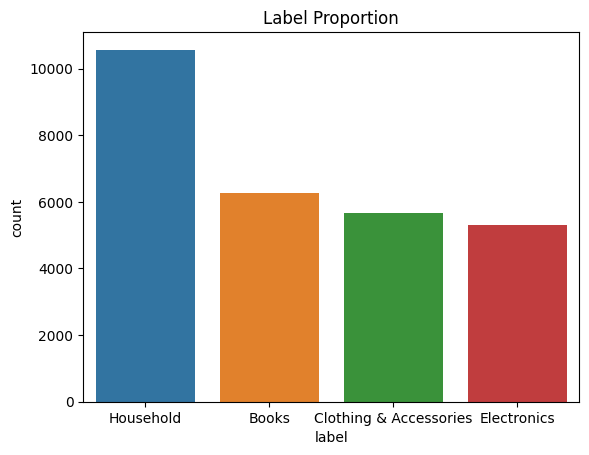

In [12]:
sns.countplot(data=df, x="label")
plt.title("Label Proportion")
plt.show()

### Wordcloud for Each Label

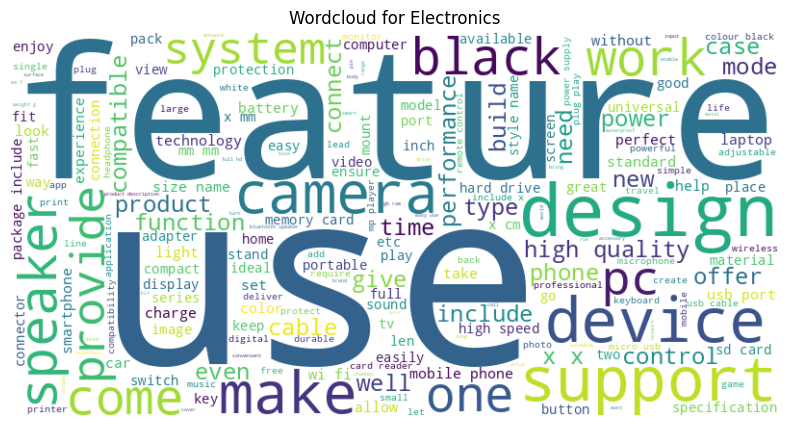

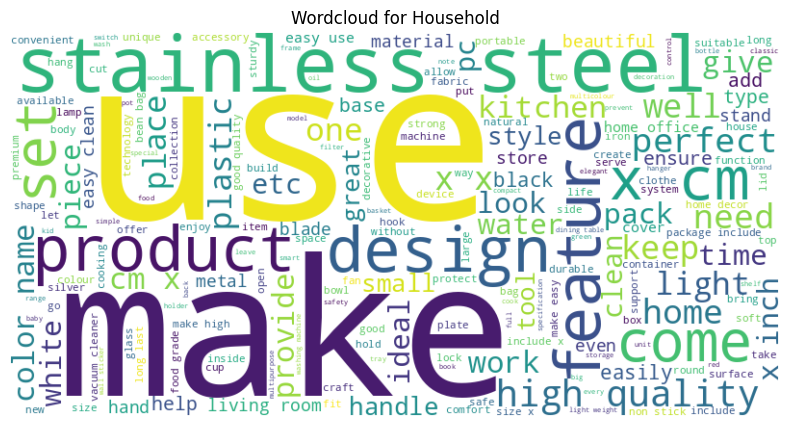

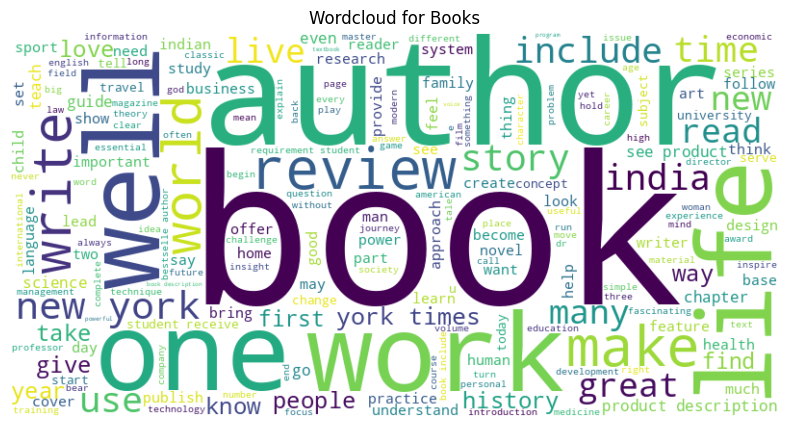

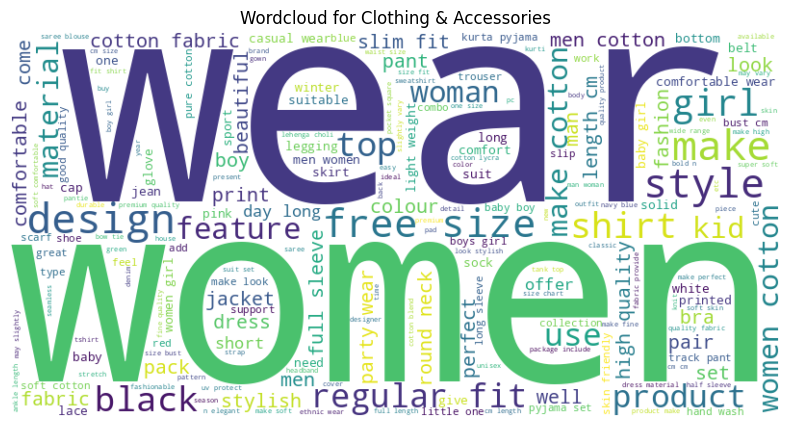

In [13]:
def generate_wordcloud(label):
    text_for_label = ' '.join(df[df['label'] == label]['text'])

    # Text tokenization using nltk
    tokens = word_tokenize(text_for_label)
    text_for_label = ' '.join(tokens)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_label)

    # Display wordcloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud for {label}')
    plt.axis('off')
    plt.show()

# Use a function for each label
labels = ["Electronics", "Household", "Books", "Clothing & Accessories"]
for label in labels:
    generate_wordcloud(label)

## Modelling

### One Hot Encoding

In [14]:
category = pd.get_dummies(df.label)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='label')
df_new

,text,Books,Clothing & Accessories,Electronics,Household
0,paper plane design framed wall hanging motivat...,0,0,0,1
1,saf floral framed painting wood inch x inch sp...,0,0,0,1
2,saf uv texture modern art print framed paintin...,0,0,0,1
3,saf flower print framed painting synthetic inc...,0,0,0,1
4,incredible gifts india wooden happy birthday u...,0,0,0,1
...,...,...,...,...,...
50402,micromax bharat plus zero impact visual displa...,0,0,1,0
50403,microsoft lumia gb g black microsoft lumia exp...,0,0,1,0
50407,microsoft lumia black gb colour black product ...,0,0,1,0
50408,karbonn titanium wind w white karbonn titanium...,0,0,1,0


### Train-Validation Split

In [15]:
text = df_new['text'].values
label = df_new[['Books', 'Clothing & Accessories', 'Electronics', 'Household']].values

In [16]:
text_train, text_val, label_train, label_val = train_test_split(text, label, test_size=0.2, random_state=42)

### Tokenization and Create Padding Sequences

In [17]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_val)

sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_val = tokenizer.texts_to_sequences(text_val)

padded_train = pad_sequences(sequences_train)
padded_val = pad_sequences(sequences_val)

### Callback Function

In [18]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            print("\naccuracy is greater than 98%, process stoped.")
            self.model.stop_training = True

callbacks = Callback()

### Create Model

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 88644 (346.27 KB)
Trainable params: 88644 (346.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [22]:
num_epochs = 20
batch_size = 64
history = model.fit(padded_train, label_train, epochs=num_epochs, batch_size=batch_size,
                    validation_data=(padded_val, label_val), verbose=1, callbacks=[callbacks])

Epoch 1/20
348/348 [==============================] - 127s 344ms/step - loss: 0.7934 - accuracy: 0.6967 - val_loss: 0.3742 - val_accuracy: 0.8856
Epoch 2/20
348/348 [==============================] - 70s 202ms/step - loss: 0.3137 - accuracy: 0.9161 - val_loss: 0.2462 - val_accuracy: 0.9327
Epoch 3/20
348/348 [==============================] - 61s 175ms/step - loss: 0.2090 - accuracy: 0.9496 - val_loss: 0.2330 - val_accuracy: 0.9416
Epoch 4/20
348/348 [==============================] - 57s 163ms/step - loss: 0.1680 - accuracy: 0.9612 - val_loss: 0.2493 - val_accuracy: 0.9358
Epoch 5/20
348/348 [==============================] - 53s 153ms/step - loss: 0.1373 - accuracy: 0.9680 - val_loss: 0.2588 - val_accuracy: 0.9329
Epoch 6/20
348/348 [==============================] - 51s 147ms/step - loss: 0.1136 - accuracy: 0.9737 - val_loss: 0.2697 - val_accuracy: 0.9345
Epoch 7/20
348/348 [==============================] - 50s 143ms/step - loss: 0.1003 - accuracy: 0.9780 - val_loss: 0.2704 - val_a

## Evaluation

### Accuracy and Loss Plot

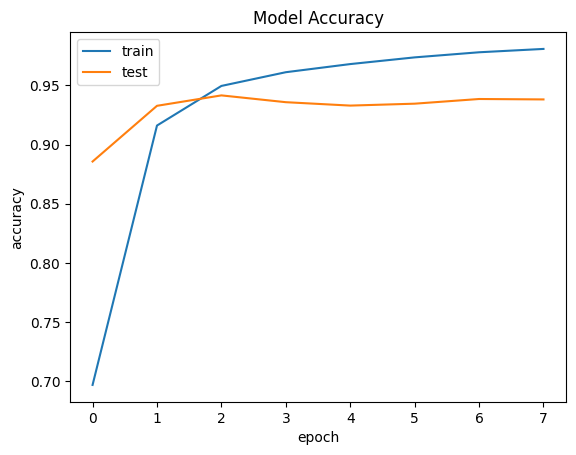

In [23]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

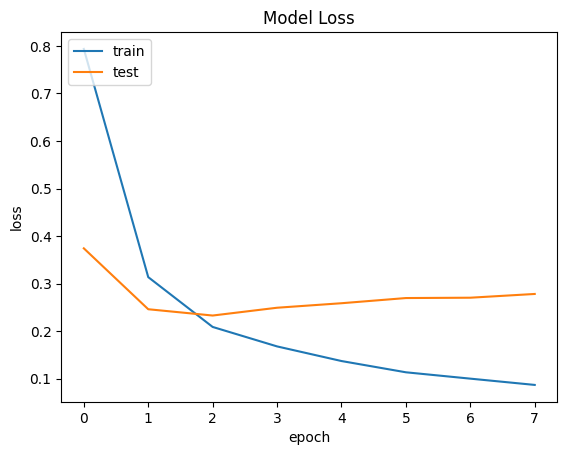

In [24]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Classification Report

In [25]:
# Predicting classes for the validation data
predictions = model.predict(padded_val)

# Converting probability values to binary classes (0 or 1)
predicted_classes = (predictions > 0.5).astype('int32')

# Creating a classification report
class_report = classification_report(label_val, predicted_classes)

print("\nClassification Report:")
print(class_report)

174/174 [==============================] - 10s 52ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1271
           1       0.95      0.97      0.96      1121
           2       0.92      0.92      0.92      1057
           3       0.94      0.94      0.94      2112

   micro avg       0.94      0.94      0.94      5561
   macro avg       0.94      0.94      0.94      5561
weighted avg       0.94      0.94      0.94      5561
 samples avg       0.94      0.94      0.94      5561



## Reference

Gautam. (2019). E commerce text dataset (version - 2) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3355823